In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties import unumpy
from scipy.optimize import curve_fit

In [2]:
paths_1 = ['datafiles/head_angle_'+str(i+1) for i in range(9)]
paths_2 = ['datafiles/f_head_angle_'+str(i+1) for i in range(6)]

In [3]:
codes_to_speeds = {'3':ufloat(3.75, 0.2), '4':ufloat(5.78, 0.2), '4a':ufloat(6.48, 0.2), '5':ufloat(7.79, 0.2),
                  '5a':ufloat(8.35, 0.2), '5b':ufloat(12.3, 0.2), '6':ufloat(14.0, 0.2), '7':ufloat(19.0, 0.2),
                   '8':ufloat(21.1, 0.2), '9':ufloat(23.2, 0.2), '10':ufloat(23.7, 0.2), '11':ufloat(24.2, 0.2),
                   '13':ufloat(25.0, 0.2)}                   

In [4]:
head_angles_a = [0, 7, 18, 30, 39, 46, 60, 69, 87]
head_angles_n = [0, 20, 34, 48, 65, 88]

Number of events collected (10 seconds times 20 Hz).

In [22]:
nn = 10*20

# Open up Data

Open up datafiles from each 10 second run and compute the mean and standard deviation for drag/lifting force. Each set of tests for a particular object (i.e testing a bunch of different wind speeds) is intended to be stored in a single DataFrame.

In [5]:
def get_data(path):
    speed_codes = np.array([])
    lift_means = np.array([]); lift_stds = np.array([])
    drag_means = np.array([]); drag_stds = np.array([])
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename, sep='\t', skiprows=5, index_col=0).astype(float) 
        speed_codes = np.append(speed_codes, filename[5:-4])
        lift_means = np.append(lift_means,  df['Lift (N)'].mean())
        lift_stds = np.append(lift_stds, df['Lift (N)'].std())
        drag_means = np.append(drag_means, df['Drag (N)'].mean())
        drag_stds = np.append(drag_stds, df['Drag (N)'].std())

    speeds = np.array([codes_to_speeds[speed_code] for speed_code in speed_codes])
    df =  pd.DataFrame({'speed_means': unumpy.nominal_values(speeds), 'speed_stds': unumpy.std_devs(speeds),
                         'lift_means':lift_means, 'lift_stds': lift_stds, 'drag_means':drag_means,
                         'drag_stds':drag_stds})
    
    return df.sort_values('speed_means')

Get the DataFrames.

In [6]:
arm_runs = [get_data(path) for path in paths_1]
no_arm_runs = [get_data(path) for path in paths_2]

In [7]:
display(arm_runs[0].head())

,speed_means,speed_stds,lift_means,lift_stds,drag_means,drag_stds
3,3.75,0.2,-0.000172,0.001323,0.010679,0.002435
4,5.78,0.2,-0.000843,0.002773,0.023265,0.004786
5,6.48,0.2,-0.001353,0.003814,0.041929,0.006591
6,7.79,0.2,-0.000511,0.003995,0.055563,0.007909
7,8.35,0.2,-0.001928,0.006162,0.074888,0.009502


# Fit All The Drag Forces To Quadratic Curves

In [8]:
def quad(x, a):
    return a*x**2

quad_params stores the values of $a$ for $F=av^2$ for each case of the head where $F$ is the drag force and $v$ is the velocity.

In [9]:
quad_params_arm = np.array([])
quad_params_arm_err = np.array([])
for df in arm_runs:
    ss = df['speed_means']; dd = df['drag_means']
    [a], [a_err] = curve_fit(quad, ss, dd, p0=(1))
    quad_params_arm = np.append(quad_params_arm, a)
    quad_params_arm_err = np.append(quad_params_arm_err, np.sqrt(a_err))
    
    
quad_params_no_arm = np.array([])
quad_params_no_arm_err = np.array([])
for df in no_arm_runs:
    ss = df['speed_means']; dd = df['drag_means']
    [a], [a_err] = curve_fit(quad, ss, dd, p0=(1))
    quad_params_no_arm = np.append(quad_params_no_arm, a)
    quad_params_no_arm_err = np.append(quad_params_no_arm_err, np.sqrt(a_err))
    

Now create quadratic curves for each head angle.

In [10]:
x = np.linspace(0, 25, 1000)
quad_fits_arm = [quad(x,quad_params_arm[i]) for i in range(9)]
quad_fits_no_arm = [quad(x,quad_params_no_arm[i]) for i in range(6)]

# Do Some Plotting

## Arms

In [11]:
choices = [0,4,8]

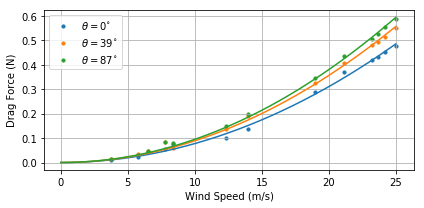

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.scatter(arm_runs[0]['speed_means'], arm_runs[0]['drag_means'],
           label=r'$\theta=0^{\circ}$', s=10) 
ax.scatter(arm_runs[4]['speed_means'], arm_runs[4]['drag_means'],
           label=r'$\theta=39^{\circ}$', s=10) 
ax.scatter(arm_runs[8]['speed_means'], arm_runs[8]['drag_means'],
           label=r'$\theta=87^{\circ}$', s=10) 

ax.plot(x, quad_fits_arm[0])
ax.plot(x, quad_fits_arm[4])
ax.plot(x, quad_fits_arm[8])

ax.legend()
ax.grid()

ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Drag Force (N)')

fig.tight_layout()
plt.savefig('arms_quad_plot.png', dpi=300)
plt.show()

## No Arms

In [13]:
choices = [0,5]

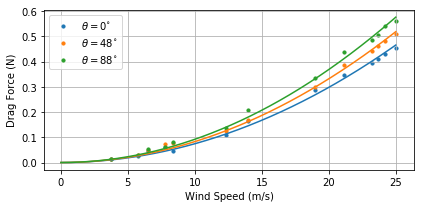

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.scatter(no_arm_runs[0]['speed_means'], no_arm_runs[0]['drag_means'],
           label=r'$\theta=0^{\circ}$', s=10) 
ax.scatter(no_arm_runs[3]['speed_means'], no_arm_runs[3]['drag_means'],
           label=r'$\theta=48^{\circ}$', s=10) 
ax.scatter(no_arm_runs[5]['speed_means'], no_arm_runs[5]['drag_means'],
           label=r'$\theta=88^{\circ}$', s=10) 

ax.plot(x, quad_fits_no_arm[0])
ax.plot(x, quad_fits_no_arm[3])
ax.plot(x, quad_fits_no_arm[5])

ax.legend()
ax.grid()

ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Drag Force (N)')

fig.tight_layout()
plt.savefig('no_arms_quad_plot.png', dpi=300)
plt.show()

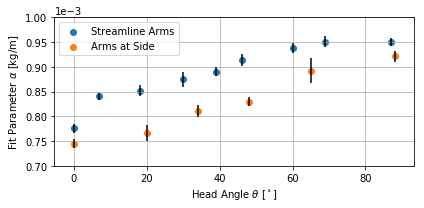

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (6,3))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.scatter(head_angles_a, quad_params_arm, label='Streamline Arms')
ax.scatter(head_angles_n, quad_params_no_arm, label='Arms at Side')
ax.errorbar(head_angles_a, quad_params_arm, yerr=quad_params_arm_err, linestyle='', color='k')
ax.errorbar(head_angles_n, quad_params_no_arm, yerr=quad_params_no_arm_err, linestyle='', color='k')

ax.set_ylim(0.0007, 0.001)
ax.set_ylabel(r'Fit Parameter $\alpha$ [kg/m]')
ax.set_xlabel(r'Head Angle $\theta$ [$^\circ$]')
ax.legend()
ax.grid()

fig.tight_layout()
plt.savefig('alpha_plot.png', dpi=300)
plt.show()